In [3]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [9]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        
        self.batch_size = batch_size
        
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype = np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches
    
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        
    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []
        
        
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha, 
                 fc1_dims = 256, fc2_dims = 256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        dist = self.actor(state)
        print(dist)
        dist = Categorical(dist)
        
        return dist
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))
        
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims = 256, fc2_dims = 256, 
                chkpt_dir = 'tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                    nn.Linear(*input_dims, fc1_dims),
                    nn.ReLU(),
                    nn.Linear(fc1_dims, fc2_dims),
                    nn.ReLU(),
                    nn.Linear(fc2_dims, 1)
            )

        self.optimizer = optim.Adam(self.parameters(), lr = alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        value = self.critic(state)
        
        return value
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))
        
        
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
                policy_clip=0.1, batch_size=64, N=2048, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        
        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
        
        
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)
        
    def save_models(self):
        print('saving models')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
        
    def load_models(self):
        print('loading models')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        
    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        
        dist = self.actor(state)
        value = self.critic(state)
        
        
        action = dist.sample()
        
        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()
        
        return action, probs, value
    
    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
                reward_arr, dones_arr, batches= self.memory.generate_batches()
            
            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                                    (1-int(dones_arr[k])) - values[k])
                    
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            
            values = T.tensor(values).to(self.actor.device)
            
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)
                
                print("states")
                print(states.shape)
                print(states)
                
                dist = self.actor(states)
                critic_value = self.critic(states)
                
                critic_value = T.squeeze(critic_value)
                
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip, 
                                                1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()
                
                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()
                
                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
            
        self.memory.clear_memory()
        
        
    
                                            
                        

tensor([[0.5272, 0.4728]], grad_fn=<SoftmaxBackward>)
tensor([[0.5288, 0.4712]], grad_fn=<SoftmaxBackward>)
tensor([[0.5271, 0.4729]], grad_fn=<SoftmaxBackward>)
tensor([[0.5173, 0.4827]], grad_fn=<SoftmaxBackward>)
tensor([[0.5272, 0.4728]], grad_fn=<SoftmaxBackward>)
tensor([[0.5290, 0.4710]], grad_fn=<SoftmaxBackward>)
tensor([[0.5270, 0.4730]], grad_fn=<SoftmaxBackward>)
tensor([[0.5289, 0.4711]], grad_fn=<SoftmaxBackward>)
tensor([[0.5268, 0.4732]], grad_fn=<SoftmaxBackward>)
tensor([[0.5287, 0.4713]], grad_fn=<SoftmaxBackward>)
tensor([[0.5226, 0.4774]], grad_fn=<SoftmaxBackward>)
tensor([[0.5280, 0.4720]], grad_fn=<SoftmaxBackward>)
tensor([[0.5218, 0.4782]], grad_fn=<SoftmaxBackward>)
tensor([[0.5162, 0.4838]], grad_fn=<SoftmaxBackward>)
tensor([[0.5203, 0.4797]], grad_fn=<SoftmaxBackward>)
tensor([[0.5149, 0.4851]], grad_fn=<SoftmaxBackward>)
tensor([[0.5184, 0.4816]], grad_fn=<SoftmaxBackward>)
tensor([[0.5130, 0.4870]], grad_fn=<SoftmaxBackward>)
tensor([[0.5106, 0.4894]], g

states
torch.Size([5, 4])
tensor([[-0.0550, -0.7883,  0.0439,  1.2261],
        [-0.1140, -0.9859,  0.1360,  1.5851],
        [ 0.0176,  0.5618, -0.0399, -0.8603],
        [-0.1496, -0.9894,  0.1944,  1.6779],
        [-0.0381,  0.1728,  0.0460, -0.3025]])
tensor([[0.4894, 0.5106],
        [0.4837, 0.5163],
        [0.6162, 0.3838],
        [0.4829, 0.5171],
        [0.5910, 0.4090]], grad_fn=<SoftmaxBackward>)
states
torch.Size([5, 4])
tensor([[-0.0904, -1.1798,  0.0991,  1.8455],
        [ 0.0288,  0.3672, -0.0571, -0.5805],
        [-0.0347,  0.3672,  0.0399, -0.5804],
        [-0.0352, -0.3975,  0.0128,  0.6289],
        [-0.0273,  0.5618,  0.0283, -0.8602]])
tensor([[0.4937, 0.5063],
        [0.6081, 0.3919],
        [0.6074, 0.3926],
        [0.5240, 0.4760],
        [0.6234, 0.3766]], grad_fn=<SoftmaxBackward>)
states
torch.Size([5, 4])
tensor([[-0.0273,  0.5618,  0.0283, -0.8602],
        [-0.0377, -0.0216,  0.0465, -0.0249],
        [-0.0311, -0.2023,  0.0061,  0.3343],
      

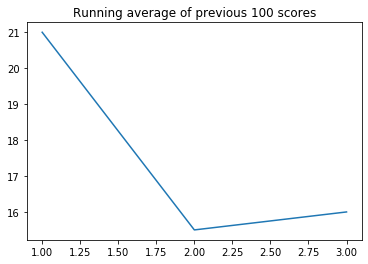

In [10]:
import gym
import numpy as np
from utils import plot_learning_curve

env = gym.make('CartPole-v0')
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size = batch_size,
             alpha = alpha, n_epochs = n_epochs, 
              input_dims = env.observation_space.shape)

n_games = 3

figure_file = 'plots/cartpole.png'

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0 
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' %score, 'avg score %.1f' %avg_score, 
          'time_steps', n_steps, 'learning_steps', learn_iters)
        
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)


